# Libraries

In [1]:
from numpy import mean, std
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn import tree
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler,PowerTransformer
import os

## Load data and resample

In [2]:
# load the dataset
def load_dataset(file_path, extra_drop_list=[]):
    # load the dataset as a dataframe
    data_df = pd.read_pickle(file_path)
    # correct data types
    fix_cols = data_df.columns[data_df.dtypes == 'object']
    data_df.loc[:, fix_cols] = data_df.loc[:, fix_cols].astype('bool')
    # remove redundant features
    drop_list = ['total_review_count', 'halal_review_count', 'halal_negation_count', 'halal_truck_count'] + extra_drop_list
    for col in drop_list:
        if col in data_df.columns:
            data_df.drop(col, inplace=True, axis=1)
    # split into features and target
    X, y = data_df.drop('halal', axis=1), data_df.halal
    return X, y

# define resampling method
def split_and_resample(X, y, test_size=0, resampling=None):
    if test_size > 0:
        # setting up testing and training sets
        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    else:
        x_train, x_test, y_train, y_test = X, pd.DataFrame(columns=X.columns, dtype=X.dtypes.values),\
                                            y, pd.Series(name=y.name, dtype=y.dtypes)
    # concatenate our training data back together
    X = pd.concat([x_train, y_train], axis=1)
    # separate minority and majority classes
    min_class = X[X.halal==X.halal.value_counts().sort_values().index[0]]
    max_class = X[X.halal==X.halal.value_counts().sort_values().index[1]]
    if not resampling:
        return x_train, y_train, x_test, y_test
    # oversampling minority
    if resampling == 'oversample':
        new_min_class = resample(min_class, replace=True, n_samples=(len(max_class)))
        upsampled = pd.concat([max_class, new_min_class])
        return upsampled.drop('halal', axis=1), upsampled.halal, x_test, y_test
    elif resampling == 'undersample':
        new_max_class = resample(max_class, replace=True, n_samples=(len(min_class)))
        downsampled = pd.concat([new_max_class, min_class])
        return downsampled.drop('halal', axis=1), downsampled.halal, x_test, y_test
    elif resampling == 'SMOTE':
        x_train, y_train = SMOTE().fit_sample(x_train, y_train)
        return x_train, y_train, x_test, y_test

# define models to test
def get_models():
    models = list()
    # BASE
    models.append(DummyClassifier(strategy='constant', constant=1))
    # CART
    models.append(DecisionTreeClassifier()) # max depth set to 15 to avoid overfitting
    # KNN
    steps = [('s',StandardScaler()),('m',KNeighborsClassifier())]
    models.append(Pipeline(steps=steps))
    # RF
    models.append(RandomForestClassifier(n_estimators=10))
    # XGBoost
    models.append(XGBClassifier(learning_rate = 0.05, n_estimators=300))
    return models

# calculate precision-recall area under curve
def pr_auc(y_true, probas_pred):
   # calculate precision-recall curve
   p, r, _ = precision_recall_curve(y_true, probas_pred)
   # calculate area under curve
   return auc(r, p)

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    # define the model evaluation the metric
    metric = make_scorer(pr_auc, needs_proba=True)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, error_score='raise')
    return scores

def evaluate_model_f1(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='f1', cv=cv, error_score='raise')
    return scores

## Compare models performance with different datasets

In [38]:
# define the location of the dataset
file_path_v1 = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num.pkl'
file_path_v2 = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num_v2.pkl'
file_path_v3 = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num_v3.pkl'
file_path_v4 = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num_v4.pkl'
file_path_v5 = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num_v5.pkl'
file_path_v6 = '/Users/wesamazaizeh/Desktop/Projects/halal_o_meter/src/features/feature_engineering/restaurant_cat_and_num_v6.pkl'

def run_model_comparison(file_path):
    # load the dataset
    X, y = load_dataset(file_path)
    # encode boolean data as integers
    y = y*1
    X.loc[:, X.dtypes == 'bool'] = X.loc[:, X.dtypes == 'bool']*1
    # split to train and test
    X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2, resampling='oversample')
    # define models
    models = get_models()
    # evaluate each model
    print('From: ', file_path.split('/')[-1].split('.')[0])
    results = []
    for i, model in enumerate(models):
        # evaluate the model and store results
        scores = evaluate_model(X_train, y_train, model)
        results.append(scores)
        # summarize performance
        print('>%s %.3f (%.3f)' % (model.__class__.__name__, mean(scores), std(scores)))
    print('\n')
    return results

res_list = []
for file_path in [file_path_v1, file_path_v2, file_path_v3, file_path_v4, file_path_v5, file_path_v6]:
    res_list.extend(run_model_comparison(file_path=file_path))

From:  restaurant_cat_and_num
>DummyClassifier 0.750 (0.000)
>DecisionTreeClassifier 0.931 (0.025)
>Pipeline 0.886 (0.030)
>RandomForestClassifier 0.942 (0.018)
>XGBClassifier 0.935 (0.020)


From:  restaurant_cat_and_num_v2
>DummyClassifier 0.750 (0.002)
>DecisionTreeClassifier 0.933 (0.017)
>Pipeline 0.914 (0.024)
>RandomForestClassifier 0.948 (0.022)
>XGBClassifier 0.942 (0.022)


From:  restaurant_cat_and_num_v3
>DummyClassifier 0.750 (0.002)
>DecisionTreeClassifier 0.924 (0.027)
>Pipeline 0.868 (0.036)
>RandomForestClassifier 0.940 (0.017)
>XGBClassifier 0.937 (0.021)


From:  restaurant_cat_and_num_v4
>DummyClassifier 0.750 (0.001)
>DecisionTreeClassifier 0.931 (0.023)
>Pipeline 0.899 (0.026)
>RandomForestClassifier 0.958 (0.021)
>XGBClassifier 0.946 (0.021)


From:  restaurant_cat_and_num_v5
>DummyClassifier 0.750 (0.002)
>DecisionTreeClassifier 0.926 (0.020)
>Pipeline 0.893 (0.027)
>RandomForestClassifier 0.958 (0.024)
>XGBClassifier 0.946 (0.022)


From:  restaurant_cat_and_nu

## Model metrics for Random Forest with oversampling to compare to Baseline-3

In [50]:
def get_rf_plotdata(file_path):
    # load the dataset
    X, y = load_dataset(file_path)
    # encode boolean data as integers
    y = y*1
    X.loc[:, X.dtypes == 'bool'] = X.loc[:, X.dtypes == 'bool']*1
    # split to train and test
    X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2, resampling='oversample')

    # initialize RF with different depths
    depths = range(1, X.shape[1])
    cv = 5
    plot_df = pd.DataFrame(columns=['depth', 'accuracy', 'precision', 'recall', 'f1'], dtype=float)
    depths_list = [[depth]*cv for depth in depths]
    plot_df['depth'] = [item for items in depths_list for item in items]
    scoring = {'acc': 'accuracy', 'prec': 'precision', 'rec': 'recall', 'f1': 'f1'}

    for i in range(0, plot_df.shape[0],50): 
        model = RandomForestClassifier(max_depth=plot_df.loc[i, 'depth'])
        # train model and collect metrics
        cv_scores = cross_validate(model, X_train, y_train, scoring = scoring, cv = cv, n_jobs = -1)
        plot_df.loc[i:i+cv-1, 'accuracy'] = cv_scores['test_acc']
        plot_df.loc[i:i+cv-1, 'precision'] = cv_scores['test_prec']
        plot_df.loc[i:i+cv-1, 'recall'] = cv_scores['test_rec']
        plot_df.loc[i:i+cv-1, 'f1'] = cv_scores['test_f1']
    return plot_df

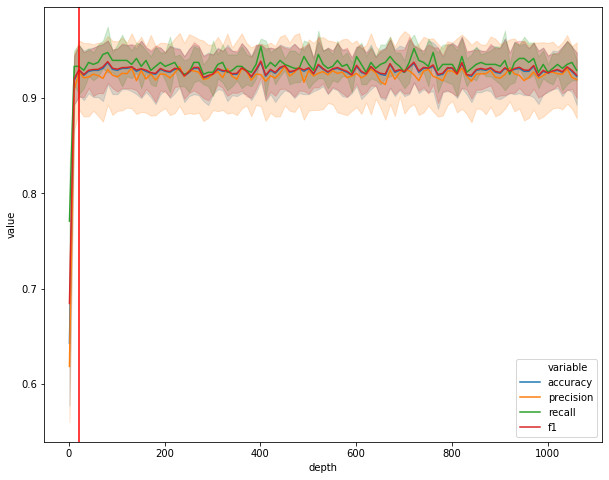

In [53]:
# # visualize decision tree metrics vs max_depth
# plot_df = get_rf_plotdata(file_path_v6)
plt.figure(figsize=(10,8))
sns.lineplot(x='depth', y='value', hue='variable', data=pd.melt(plot_df, ['depth']))
plt.axvline(x=20, color='red')
plt.show()

ROC-AUC:   0.676
Accuracy:  0.812
Precision: 0.807
Recall:    0.975
f1:        0.883
Classification report: 
               precision    recall  f1-score   support

       False       0.85      0.38      0.52        45
        True       0.81      0.97      0.88       120

    accuracy                           0.81       165
   macro avg       0.83      0.68      0.70       165
weighted avg       0.82      0.81      0.78       165

Confusion matrix: 
 [[ 17  28]
 [  3 117]]


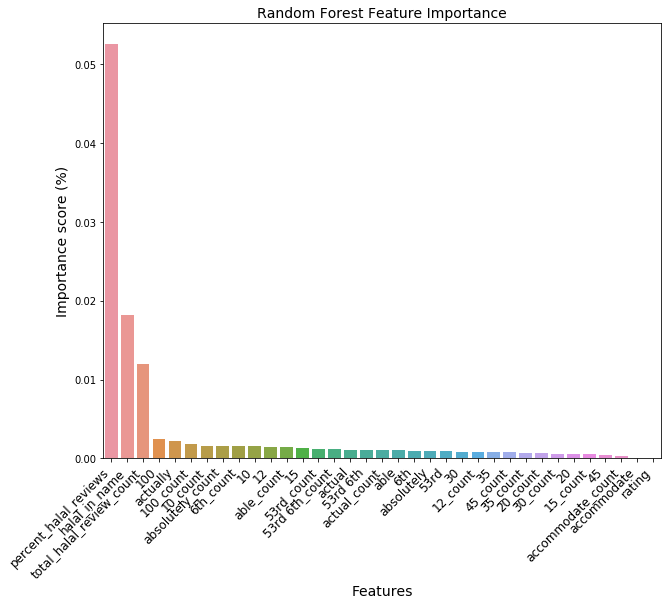

In [54]:
# use max depth of 20
X, y = load_dataset(file_path_v6)
X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2, resampling='oversample')
model = RandomForestClassifier(max_depth=20)
model.fit(X_train, y_train)

# model performance on test set
y_pred = model.predict(X_test)
print('ROC-AUC:   %.3f' % roc_auc_score(y_test, y_pred))
print('Accuracy:  %.3f'  % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall:    %.3f' % recall_score(y_test, y_pred))
print('f1:        %.3f' % f1_score(y_test, y_pred))
print('Classification report: \n', classification_report(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))


# Feature importance from RF
imp_plot_df = pd.DataFrame(data={'importances': model.feature_importances_[:35], 'features': X.columns[:35]})

# plot
plt.figure(figsize=(10,8))
g = sns.barplot(x=imp_plot_df['features'], y=imp_plot_df['importances'],
                order=imp_plot_df.sort_values('importances', ascending=False).features)
g_labels = g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_title('Random Forest Feature Importance', size=14)
g.set_ylabel('Importance score (%)', size=14)
g.set_xlabel('Features', size=14)
g.set_xticklabels(g.get_xticklabels(), size=12)
plt.show()

## Try XGBoost with oversampling

In [55]:
# load the dataset
X, y = load_dataset(file_path_v6)
# encode boolean data as integers
y = y*1
X.loc[:, X.dtypes == 'bool'] = X.loc[:, X.dtypes == 'bool']*1
# split to train and test
X_train, y_train, X_test, y_test = split_and_resample(X, y, test_size=0.2, resampling='oversample')
# define model 
model = XGBClassifier(max_depth=20,
                        subsample=0.8,
                        objective='binary:logistic',
                        n_estimators=300,
                        learning_rate = 0.001)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train.values.ravel(), early_stopping_rounds=15, eval_metric='aucpr', eval_set=eval_set)
# evaluate against test set
y_pred = model.predict(X_test)
print('Accuracy:  %.3f'  % accuracy_score(y_test, y_pred))
print('Precision: %.3f' % precision_score(y_test, y_pred))
print('Recall:    %.3f' % recall_score(y_test, y_pred))
print('f1:        %.3f' % f1_score(y_test, y_pred))
print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))
print('Classification report:\n', classification_report(y_test, y_pred))

[0]	validation_0-aucpr:0.95732	validation_1-aucpr:0.90590
Multiple eval metrics have been passed: 'validation_1-aucpr' will be used for early stopping.

Will train until validation_1-aucpr hasn't improved in 15 rounds.
[1]	validation_0-aucpr:0.98113	validation_1-aucpr:0.91619
[2]	validation_0-aucpr:0.98622	validation_1-aucpr:0.91394
[3]	validation_0-aucpr:0.98957	validation_1-aucpr:0.92389
[4]	validation_0-aucpr:0.98969	validation_1-aucpr:0.92226
[5]	validation_0-aucpr:0.98857	validation_1-aucpr:0.92240
[6]	validation_0-aucpr:0.98923	validation_1-aucpr:0.92323
[7]	validation_0-aucpr:0.99004	validation_1-aucpr:0.92206
[8]	validation_0-aucpr:0.98984	validation_1-aucpr:0.91988
[9]	validation_0-aucpr:0.99063	validation_1-aucpr:0.91765
[10]	validation_0-aucpr:0.99126	validation_1-aucpr:0.91717
[11]	validation_0-aucpr:0.99165	validation_1-aucpr:0.91962
[12]	validation_0-aucpr:0.99257	validation_1-aucpr:0.92110
[13]	validation_0-aucpr:0.99314	validation_1-aucpr:0.91990
[14]	validation_0-aucpr